In [1]:
# %pip install aiohttp
# %pip install mysql-connector-python
# %pip install nest_asyncio
# %pip install lenskit --upgrade
# %pip install psycopg2

In [2]:
import asyncio
import aiohttp
import json
import sqlite3
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String
import urllib
from pandas.io import sql
from datetime import datetime
import numpy as np
import requests
from time import perf_counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nest_asyncio
nest_asyncio.apply()

# Performance Testing

In [3]:
class ConfigReader:
    def get_value(self, key):
        with open('config.json') as json_data_file:
            data = json.load(json_data_file)
        return data[key]

In [4]:
class DbManager:
    def __init__(self):
        reader = ConfigReader()
        db_connection = reader.get_value("db_connection")        
        self.conn_string = '{db_engine}{connector}://{user}:{password}@{server}/{database}'.format(
            db_engine=db_connection['db_engine'],
            connector=db_connection['connector'],
            user=db_connection['user'],
            password=db_connection['password'],
            server=db_connection['server'],
            database=db_connection['database'])

    def get_users(self):
        return sql.read_sql("SELECT distinct user FROM rating;", create_engine(self.conn_string))

## Get random users

In [5]:
n_rand_users = num_requests = 1000
dbManager = DbManager()
db_users = dbManager.get_users()
n_rand_users = db_users.sample(n=n_rand_users)

## Test recommendation endpoint

In [6]:
base_url = 'http://127.0.0.1:8000'
#algo_rec = 'popular'
#algo_pred = 'itemitem' # 'biasedmf'
n_recs = 5
items = "10,20,30,40,50"
pred_algos = ['bias','itemitem','useruser','biasedmf','implicitmf','funksvd']
rec_algos = ['popular']

### Semaphore performance

In [7]:
import os
throughputs = []

def print_stats(times, time_taken_all, num_requests):
    print(f'Total response time: {time_taken_all}')
    print(f'Throughput (requests per second): {num_requests / time_taken_all}')
    print(f'Peak response time: {max(times)}')
    print(f'Mean response time: {np.mean(times)}')
    print(f'99 percentile: {np.quantile(times, 0.99)}')

def plot_numbers(file_name):
    resp_time_per_request = np.genfromtxt(file_name, delimiter=',')
    plt.plot(resp_time_per_request)
    plt.show()
    
def hist_numbers(file_name):
    resp_time_per_request = np.genfromtxt(file_name, delimiter=',')
    plt.hist(resp_time_per_request, bins='auto')
    plt.show()

# Predictions    
async def get_preds_sem(num_sem, algo_pred, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds_with_sem(row['user'], algo_pred, items, session, sem, times))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_preds_with_sem(user, algo, items, session, sem, times):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem(user, algo, items, session, times)        
        
async def get_user_preds_sem(user, algo, items, session, times):
    url = f'{base_url}/algorithms/{algo}/predictions?user_id={user}&items={items}'
    start = perf_counter()
    async with session.get(url) as resp:
        data = await resp.json()    
        time_taken = perf_counter() - start
        times.append(time_taken)
        
# Recommendations
async def get_recs_sem(num_sem, algo_rec, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_recs_with_sem(row['user'], algo_rec, n_recs, session, sem, times))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_recs_with_sem(user, algo, n_recs, session, sem, times):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem(user, algo, n_recs, session, times)        
        
async def get_user_recs_sem(user, algo, n_recs, session, times):
    url = f'{base_url}/algorithms/{algo}/recommendations?user_id={user}&num_recs={n_recs}'
    start = perf_counter()
    async with session.get(url) as resp:
        data = await resp.json()    
        time_taken = perf_counter() - start
        times.append(time_taken)   

### Warm up phase

In [16]:
async def warm_up_async(current_algo=None, num_workers=16, display_logs=True):
    warm_up_user = 1
    times = []
    tasks = []
    async with aiohttp.ClientSession() as session:
        for algo in pred_algos:
            if current_algo is None or algo == current_algo:
                for w in range(num_workers * 2):
                    if display_logs:
                        print(f'Calling {algo}. Worker number: {w + 1}')
                    task = asyncio.ensure_future(get_user_preds_sem(warm_up_user, algo, items, session, times))
                    tasks.append(task)
        responses = await asyncio.gather(*tasks)

In [17]:
def warm_up(current_algo=None, num_workers=16, display_logs=True):
    loop = asyncio.get_event_loop()
    future = asyncio.ensure_future(warm_up_async(current_algo, num_workers, display_logs))
    loop.run_until_complete(future)

In [54]:
warm_up()

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling bias. Worker number: 9
Calling bias. Worker number: 10
Calling bias. Worker number: 11
Calling bias. Worker number: 12
Calling bias. Worker number: 13
Calling bias. Worker number: 14
Calling bias. Worker number: 15
Calling bias. Worker number: 16
Calling bias. Worker number: 17
Calling bias. Worker number: 18
Calling bias. Worker number: 19
Calling bias. Worker number: 20
Calling bias. Worker number: 21
Calling bias. Worker number: 22
Calling bias. Worker number: 23
Calling bias. Worker number: 24
Calling bias. Worker number: 25
Calling bias. Worker number: 26
Calling bias. Worker number: 27
Calling bias. Worker number: 28
Calling bias. Worker number: 29
Calling bias. Worker number: 30
Calling bias. Worker number: 31
Calling bias. Wor

KeyboardInterrupt: 

### Call predict and recommend from server for canonical config

#### Predictions for different algorithms

Algorithm: bias
Number of requests: 1000
Total response time: 40.862228551999976
Throughput (requests per second): 24.472478262594798
Peak response time: 0.6102552279999998
Mean response time: 0.3247120795950006
99 percentile: 0.5040635432999994


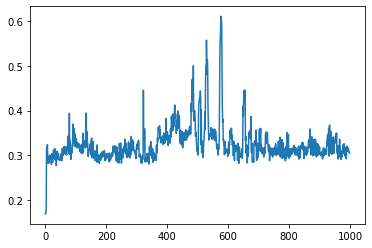

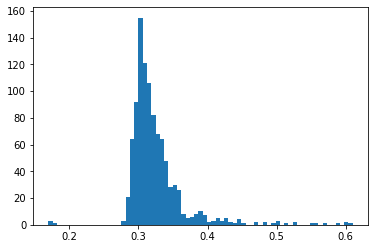

---------------------

Algorithm: itemitem
Number of requests: 1000
Total response time: 133.893338584
Throughput (requests per second): 7.4686314537794205
Peak response time: 13.300732983999978
Mean response time: 1.0648159174899998
99 percentile: 3.4594864468000175


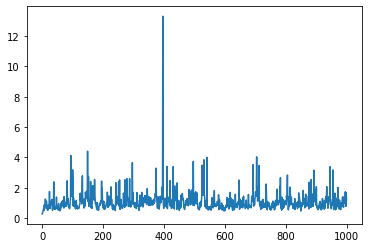

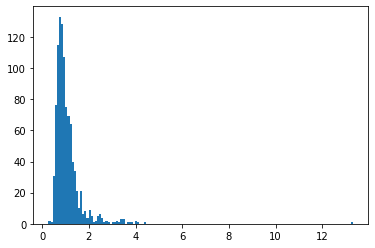

---------------------

Algorithm: useruser
Number of requests: 1000
Total response time: 126.65488612800004
Throughput (requests per second): 7.895471154499159
Peak response time: 1.4058934759999602
Mean response time: 1.0086880410090011
99 percentile: 1.3240882784601022


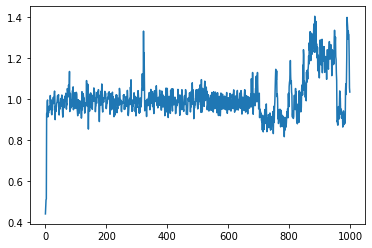

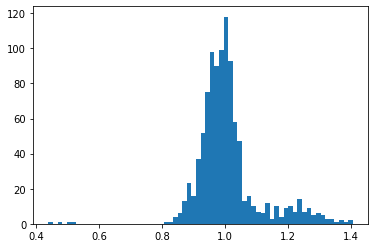

---------------------

Algorithm: biasedmf
Number of requests: 1000
Total response time: 628.174279747
Throughput (requests per second): 1.5919149068038163
Peak response time: 7.101268454999968
Mean response time: 5.006404337635997
99 percentile: 6.574937884570081


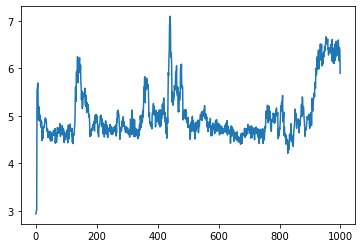

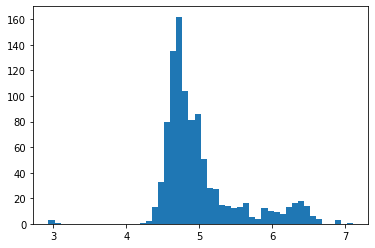

---------------------

Algorithm: implicitmf
Number of requests: 1000
Total response time: 68.56399007300001
Throughput (requests per second): 14.584915477283351
Peak response time: 0.8552128950000224
Mean response time: 0.5452830585869956
99 percentile: 0.6840114672299842


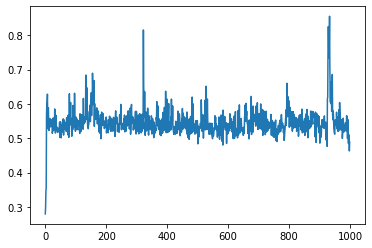

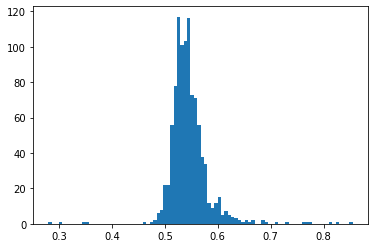

---------------------

Algorithm: funksvd
Number of requests: 1000
Total response time: 67.5312412589999
Throughput (requests per second): 14.807961194800782
Peak response time: 0.8141309869999986
Mean response time: 0.5365512504510005
99 percentile: 0.7221306263299061


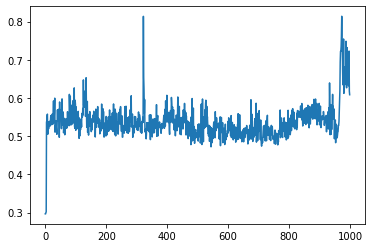

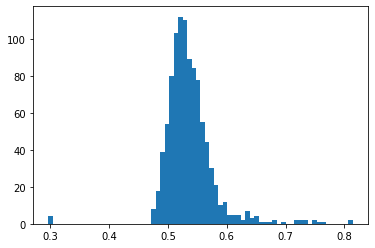

---------------------



In [15]:
for algo in pred_algos:
    file_name = f'preds_{algo}_parallel_threads_8_workers_4_num_req_{num_requests}.csv'
    loop = asyncio.get_event_loop()
    print(f'Algorithm: {algo}')
    future = asyncio.ensure_future(get_preds_sem(8, algo, file_name, True))
    loop.run_until_complete(future)
#    plot_numbers(file_name)
    hist_numbers(file_name)
    print('---------------------')
    print('')

#### Throughputs

In [ ]:
# throughput_file_name = 'throughput_single_multiple_requests.csv'
# np.savetxt(throughput_file_name, throughputs , delimiter=',')

In [ ]:
# throughputs_from_file = np.genfromtxt(throughput_file_name, delimiter=',')
# threads = [1, 2, 4, 8, 16]
# y_pos = np.arange(len(throughputs_from_file))

# plt.bar(y_pos, throughputs_from_file, align='center', alpha=0.5)
# plt.xticks(y_pos, threads)
# plt.ylabel('Throughput')
# plt.title('Throughput by threads')

# plt.show()

##### Boxplot for all prediction scenarios

In [ ]:
# preds_scenarios = [np.genfromtxt(f'parallel_threads_1_workers_4_num_req_{num_requests}.csv', delimiter=','),
#    np.genfromtxt(f'parallel_threads_2_workers_4_num_req_{num_requests}.csv', delimiter=','),
#    np.genfromtxt(f'parallel_threads_4_workers_4_num_req_{num_requests}.csv', delimiter=','),
#    np.genfromtxt(f'parallel_threads_8_workers_4_num_req_{num_requests}.csv', delimiter=','),
#    np.genfromtxt(f'parallel_threads_16_workers_4_num_req_{num_requests}.csv', delimiter=',')
#    ]

# a4_dims = (12, 12)
# fig, ax = plt.subplots(figsize=a4_dims)

# sns.boxplot(ax=ax, data=preds_scenarios)
# plt.xticks([0, 1, 2, 3, 4], [1, 2, 4, 8, 16])

#### Recommendations

Number of requests: 1000
Total response time: 3.780431953000516
Throughput (requests per second): 264.5200369778653
Peak response time: 0.04821931600054086
Mean response time: 0.027970573934006097
99 percentile: 0.03599552225010484


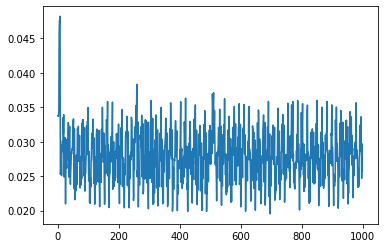

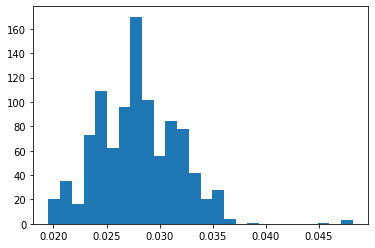

In [20]:
algo_rec = 'popular'
file_name = f'recs_{algo_rec}_parallel_threads_8_workers_4_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_recs_sem(8, algo_rec, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

### Call server using different workers in parallel - need to restart the server

In [70]:
throughputs = []
current_algo = 'biasedmf'

In [71]:
def call_server(file_name):
    loop = asyncio.get_event_loop()
    future = asyncio.ensure_future(get_preds_sem(8, current_algo, file_name, True))
    loop.run_until_complete(future)
#    plot_numbers(file_name)
    hist_numbers(file_name)

#### Four threads and one worker 

In [72]:
num_workers = 1
warm_up(current_algo, num_workers)

Calling biasedmf. Worker number: 1


Number of requests: 1000
Total response time: 1814.9676098359996
Throughput (requests per second): 0.5509740199112203
Peak response time: 21.630597344999842
Mean response time: 14.46042073130088
99 percentile: 17.17849736731048


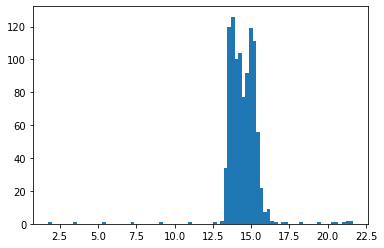

In [73]:
file_name = f'preds_{algo}_parallel_threads_8_workers_{num_workers}_num_req_{num_requests}.csv'
call_server(file_name)

#### Four threads and two workers

In [104]:
num_workers = 2
warm_up(current_algo, num_workers)

Calling biasedmf. Worker number: 1
Calling biasedmf. Worker number: 2
Calling biasedmf. Worker number: 3
Calling biasedmf. Worker number: 4


Number of requests: 1000
Total response time: 964.4838570739994
Throughput (requests per second): 1.0368239889817832
Peak response time: 12.68013277099817
Mean response time: 7.687203137790057
99 percentile: 11.007155182500828


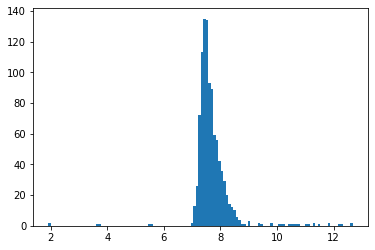

In [105]:
file_name = f'preds_{algo}_parallel_threads_8_workers_{num_workers}_num_req_{num_requests}.csv'
call_server(file_name)

#### Four threads and four workers

In [82]:
num_workers = 4
warm_up(current_algo, num_workers)

Calling biasedmf. Worker number: 1
Calling biasedmf. Worker number: 2
Calling biasedmf. Worker number: 3
Calling biasedmf. Worker number: 4


Number of requests: 1000
Total response time: 555.7299853480035
Throughput (requests per second): 1.7994350248597621
Peak response time: 5.155215617000067
Mean response time: 4.4299435244089835
99 percentile: 4.988533903970274


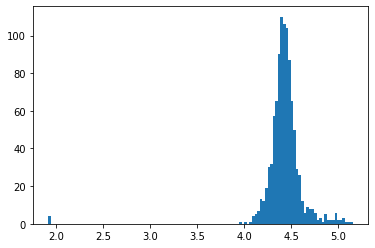

In [83]:
file_name = f'preds_{algo}_parallel_threads_8_workers_{num_workers}_num_req_{num_requests}.csv'
call_server(file_name)

#### Four threads and eight workers

In [91]:
num_workers = 8
warm_up(current_algo, num_workers)

Calling biasedmf. Worker number: 1
Calling biasedmf. Worker number: 2
Calling biasedmf. Worker number: 3
Calling biasedmf. Worker number: 4
Calling biasedmf. Worker number: 5
Calling biasedmf. Worker number: 6
Calling biasedmf. Worker number: 7
Calling biasedmf. Worker number: 8
Calling biasedmf. Worker number: 9
Calling biasedmf. Worker number: 10
Calling biasedmf. Worker number: 11
Calling biasedmf. Worker number: 12
Calling biasedmf. Worker number: 13
Calling biasedmf. Worker number: 14
Calling biasedmf. Worker number: 15
Calling biasedmf. Worker number: 16


Number of requests: 1000
Total response time: 444.8871672740024
Throughput (requests per second): 2.247760946056032
Peak response time: 5.0880468460018164
Mean response time: 3.5477909702800536
99 percentile: 4.7287102993423105


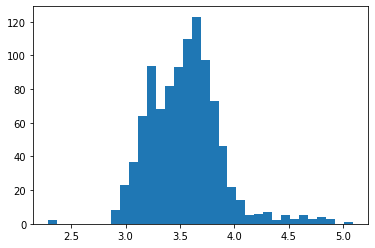

In [92]:
file_name = f'preds_{algo}_parallel_threads_8_workers_{num_workers}_num_req_{num_requests}.csv'
call_server(file_name)

#### Four threads and sixteen workers

In [93]:
num_workers = 16
warm_up(current_algo, num_workers)

Calling biasedmf. Worker number: 1
Calling biasedmf. Worker number: 2
Calling biasedmf. Worker number: 3
Calling biasedmf. Worker number: 4
Calling biasedmf. Worker number: 5
Calling biasedmf. Worker number: 6
Calling biasedmf. Worker number: 7
Calling biasedmf. Worker number: 8
Calling biasedmf. Worker number: 9
Calling biasedmf. Worker number: 10
Calling biasedmf. Worker number: 11
Calling biasedmf. Worker number: 12
Calling biasedmf. Worker number: 13
Calling biasedmf. Worker number: 14
Calling biasedmf. Worker number: 15
Calling biasedmf. Worker number: 16
Calling biasedmf. Worker number: 17
Calling biasedmf. Worker number: 18
Calling biasedmf. Worker number: 19
Calling biasedmf. Worker number: 20
Calling biasedmf. Worker number: 21
Calling biasedmf. Worker number: 22
Calling biasedmf. Worker number: 23
Calling biasedmf. Worker number: 24
Calling biasedmf. Worker number: 25
Calling biasedmf. Worker number: 26
Calling biasedmf. Worker number: 27
Calling biasedmf. Worker number: 28
C

Number of requests: 1000
Total response time: 486.1705974409997
Throughput (requests per second): 2.056891151508514
Peak response time: 5.139888297999278
Mean response time: 3.8816242125489118
99 percentile: 4.794696600568313


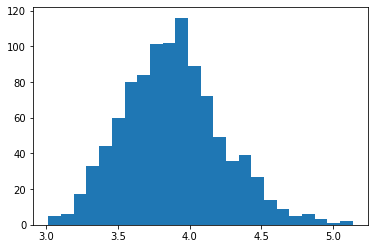

In [94]:
file_name = f'preds_{algo}_parallel_threads_8_workers_{num_workers}_num_req_{num_requests}.csv'
call_server(file_name)

#### Throughput by number of workers

In [109]:
#throughputs = [0.5509740199112203, 1.0368239889817832, 1.7994350248597621, 2.247760946056032, 2.056891151508514]

In [107]:
throughput_file_name_workers = 'throughput_single_multiple_workers.csv'
np.savetxt(throughput_file_name_workers, throughputs , delimiter=',')

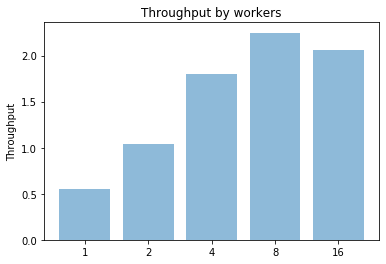

In [108]:
throughputs_workers_from_file = np.genfromtxt(throughput_file_name_workers, delimiter=',')
workers = [1, 2, 4, 8, 16]
y_pos = np.arange(len(throughputs_workers_from_file))

plt.bar(y_pos, throughputs_workers_from_file, align='center', alpha=0.5)
plt.xticks(y_pos, workers)
plt.ylabel('Throughput')
plt.title('Throughput by workers')

plt.show()

### Lenskit

In [11]:
import sys
import math
from binpickle import BinPickleFile
from pathlib import Path

directory_path = 'models'
algo_pred_lkpy = 'bias.bpk'

def load_for_shared_mem(file_name):
    full_file_name = Path(directory_path) / file_name

    binpickle_file = BinPickleFile(full_file_name, direct=True)
    model = binpickle_file.load()
    return model

def get_predictions_from_model(model, user, items):
    try:
        results = []
        df_preds = model.predict_for_user(user, items)
        for index, value in df_preds.iteritems():
            if not math.isnan(value):
                results.append({'item': index, 'score': value})
        return results
    except:
        print(f"Unexpected preds error for user: {user}, with items: {items}. Error: {sys.exc_info()[0]}")
        raise
        

# Predictions    
async def get_preds_threads_lkpy(num_sem, model, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds_with_threads_lkpy(row['user'], algo_pred_lkpy, items, session, sem, times, model))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.asarray(times)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_preds_with_threads_lkpy(user, algo, items, session, sem, times, model):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_threads_lkpy(user, algo, items, session, times, model)        
        
async def get_user_preds_threads_lkpy(user, algo, items, session, times, model):
    try:
        start = perf_counter()
        results = []
        df_preds = model.predict_for_user(user, items.split(','))
        for index, value in df_preds.iteritems():
            if not math.isnan(value):
                results.append({'item': index, 'score': value})
                
        time_taken = perf_counter() - start
        times.append(time_taken)
        return results
    except:
        print(f"Unexpected preds error for user: {user}, with items: {items}. Error: {sys.exc_info()[0]}")
        raise        

Number of requests: 1000
Total response time: 12.70856934999938
Throughput (requests per second): 78.6870632295089
Peak response time: 0.01810653699976683
Mean response time: 0.012487252753024222
99 percentile: 0.015544317380117715


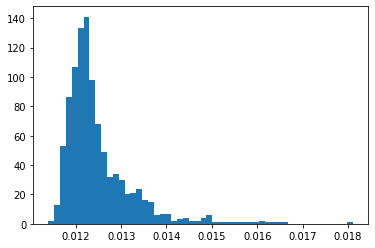

In [49]:
algo = 'bias'
model = load_for_shared_mem(f'{algo}.bpk')
file_name = f'lkpy_parallel_threads_8_{algo}__num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_threads_lkpy(8, model, file_name))
loop.run_until_complete(future)
#plot_numbers(file_name)
hist_numbers(file_name)

In [50]:
warm_up(algo, 8, False)

Algorithm: bias
Number of requests: 1000
Total response time: 37.7498540760007
Throughput (requests per second): 26.49016862387676
Peak response time: 0.7274802209994959
Mean response time: 0.29975297041298654
99 percentile: 0.4806189410806473


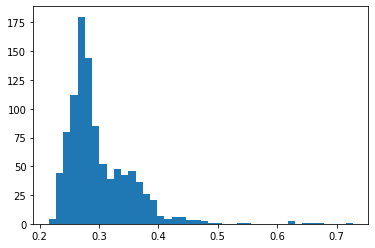

In [51]:
file_name = f'preds_{algo}_parallel_threads_8_workers_8_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
print(f'Algorithm: {algo}')
future = asyncio.ensure_future(get_preds_sem(8, algo, file_name, True))
loop.run_until_complete(future)
#plot_numbers(file_name)
hist_numbers(file_name)